In [1]:
# https://www.twilio.com/blog/2017/12/sentiment-analysis-scikit-learn.html

In [2]:
'''
Técnicas Envolvidas
• Análise descritiva de dados.
• Classificação binária.
• Clustering.
Desafios
Para esse projeto, alguns desafios são:
• Classificação conforme like/dislike vinculado aos comentários, extrapolar like/dislike de quem comentou e não
classificou.
• Clustering baseado em comentários.
• Análise de mudança de sentimento no decorrer do tempo.
'''

'\nTécnicas Envolvidas\n• Análise descritiva de dados.\n• Classificação binária.\n• Clustering.\nDesafios\nPara esse projeto, alguns desafios são:\n• Classificação conforme like/dislike vinculado aos comentários, extrapolar like/dislike de quem comentou e não\nclassificou.\n• Clustering baseado em comentários.\n• Análise de mudança de sentimento no decorrer do tempo.\n'

In [39]:
import pandas as pd
import numpy as np
from collections import Counter
import operator
import json
import matplotlib.pyplot as plt
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.callbacks import *
from keras.layers import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [37]:
def mlp_model(hidden_units, classes, top_words, embedding_size, max_len):
    
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_len))
    model.add(Flatten())
    model.add(Dense(hidden_units, activation='relu'))
    
    if classes > 2:
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [38]:
def cnn_model(filters, kernel_size, hidden_units, classes, top_words, embedding_size, max_len):
    
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_len))
    model.add(Conv1D(filters, kernel_size, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hidden_units, activation='relu'))
    
    if classes > 2:
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [36]:
def lstm_model(lstm_units, classes, top_words, embedding_size, max_len):
    
    model = Sequential()
    model.add(Embedding(top_words, embedding_size, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(Dropout(0.2))
    
    if classes > 2:
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [4]:
UScomments = pd.read_csv('data/UScomments.csv', error_bad_lines = False)

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
C:\Users\fbrolesi\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
UScommentTest = UScomments.head(50000)

In [6]:
UScommentTest.head()

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [7]:
%%time
# TODO: se o arquivo "polarity.csv" exisit, então carrega o arquivo
pol = [] # list which will contain the polarity of the comments
for i in UScommentTest.comment_text.values:
    try:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    except:
        pol.append(0)

Wall time: 33.9 s


In [8]:
# pd.DataFrame(pol).to_csv('polarity.csv')

In [9]:
pol_ranges = [int(x) for x in pol]# [int(x) / 2 for x in [y * 2 for y in pol]]

In [10]:
UScommentTest['sentiment'] = pol_ranges

C:\Users\fbrolesi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
UScommentTest.head()

,video_id,comment_text,likes,replies,sentiment
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0,0
4,XpVt6Z1Gjjo,trending 😉,3,0,0


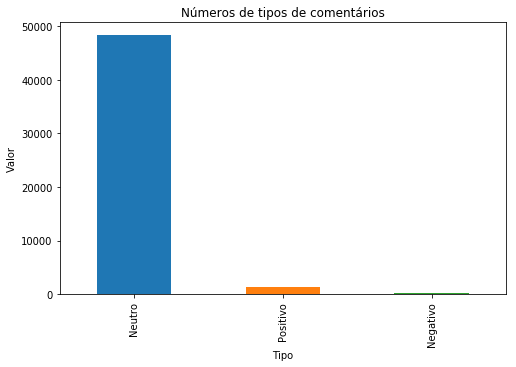

In [12]:
# TODO: Ordenar pelos dados de replace -1 ~ 1
UScommentTest['sentiment'].replace({1:'Positivo', 0:'Neutro', -1:'Negativo'}).value_counts().plot(kind='bar',figsize=(8,5));
plt.title('Números de tipos de comentários');
plt.xlabel('Tipo');
plt.ylabel('Valor');

In [13]:
## TODO: PLOTs

In [14]:
UScommentTest = UScommentTest[UScommentTest.sentiment != 0]
UScommentTest['text'] = UScommentTest['comment_text'].apply(lambda x: x.lower())
UScommentTest['text'] = UScommentTest['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [15]:
UScommentTest.head()

,video_id,comment_text,likes,replies,sentiment,text
64,XpVt6Z1Gjjo,yu are the best,1,0,1,yu are the best
156,cLdxuaxaQwc,Power is the disease. Care is the cure. Keep...,0,0,1,power is the disease care is the cure keep c...
227,WYYvHb03Eog,YAS Can't wait to get it! I just need to sell ...,0,0,1,yas cant wait to get it i just need to sell my...
307,sjlHnJvXdQs,This is priceless,0,0,1,this is priceless
319,sjlHnJvXdQs,Summed up perfectly,0,0,1,summed up perfectly


In [16]:
print(UScommentTest[UScommentTest['sentiment'] == 1].size)
print(UScommentTest[UScommentTest['sentiment'] == -1].size)

max_fatures = 100
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(UScommentTest['text'].values)
X = tokenizer.texts_to_sequences(UScommentTest['text'].values)
X = pad_sequences(X)    

8298
1554


In [17]:
X[401]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  5, 42, 13, 23])

In [18]:
embed_dim = 128
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 47, 128)           12800     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 32)            12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               184250    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 502       
Total para

In [19]:
Y = pd.get_dummies(UScommentTest['sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_test.shape,Y_test.shape)

(1100, 47) (1100, 2)
(542, 47) (542, 2)
(542, 47) (542, 2)


In [20]:
Y_train_compact = Y_train[1].copy()

In [21]:
Y_train_compact = Y_train_compact.to_frame()

In [22]:
Y_train_compact = Y_train_compact[1].map({0: -1, 1: 1})

In [23]:
balancer = SMOTE()
x_resampled, y_resampled = balancer.fit_sample(X_train, Y_train_compact)

In [24]:
def describe(x, y, classes):
    print('amostras:', x.shape[0])
    print('características:', x.shape[1])

    _, counts = np.unique(y, return_counts=True)
    print('frequência das classes:', dict(zip(classes, counts)))

In [25]:
describe(x_resampled, y_resampled, ['Positivo', 'Negativo'])

amostras: 1832
características: 47
frequência das classes: {'Positivo': 916, 'Negativo': 916}


In [26]:
Y_resampled = pd.DataFrame({'1': y_resampled, '-1': y_resampled})

In [27]:
Y_resampled['-1'] = Y_resampled['-1'].replace(1,0)
Y_resampled['1'] = Y_resampled['1'].replace(-1,0)

In [28]:
validation_size = 50

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [29]:
print('X_train', np.shape(x_resampled))
print('Y_train', np.shape(Y_resampled))
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))
print('X_validate', np.shape(X_validate))
print('Y_validate', np.shape(Y_validate))

X_train (1832, 47)
Y_train (1832, 2)
X_test (492, 47)
Y_test (492, 2)
X_validate (50, 47)
Y_validate (50, 2)


In [30]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=1e-6, 
                           patience=3, 
                           verbose=0, 
                           mode='auto', 
                           baseline=None)

In [31]:
%%time
batch_size = 16
model.fit(x_resampled, Y_resampled, epochs = 21, batch_size = batch_size, verbose = 1, validation_data=[X_validate, Y_validate], callbacks=[early_stop])

Train on 1832 samples, validate on 50 samples
Epoch 1/21
1832/1832 [==============================] - 2s 937us/step - loss: -3.0993 - acc: 0.5071 - val_loss: 2.0922 - val_acc: 0.5000
Epoch 2/21
1832/1832 [==============================] - 1s 611us/step - loss: -3.7429 - acc: 0.5963 - val_loss: 1.8106 - val_acc: 0.8400
Epoch 3/21
1832/1832 [==============================] - 1s 609us/step - loss: -3.8331 - acc: 0.6632 - val_loss: 1.7448 - val_acc: 0.8600
Epoch 4/21
1832/1832 [==============================] - 1s 623us/step - loss: -3.8650 - acc: 0.6845 - val_loss: 1.7152 - val_acc: 0.8500
Epoch 5/21
1832/1832 [==============================] - 1s 612us/step - loss: -3.8819 - acc: 0.6900 - val_loss: 1.6832 - val_acc: 0.8800
Epoch 6/21
1832/1832 [==============================] - 1s 612us/step - loss: -3.9002 - acc: 0.6973 - val_loss: 1.6944 - val_acc: 0.8700
Epoch 7/21
1832/1832 [==============================] - 1s 613us/step - loss: -3.9086 - acc: 0.7028 - val_loss: 1.7088 - val_acc: 0.

In [32]:
score, acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

492/492 [==============================] - 0s 159us/step
score: 1.28
acc: 0.84


In [33]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    print(X_validate[x].reshape(1,X_test.shape[1]))
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 1)[0]
    if np.argmax(result) == np.argmax(Y_validate.values[x]):
        if np.argmax(Y_validate.values[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate.values[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt * 100, "% - ", str(pos_cnt))
print("neg_acc", neg_correct/neg_cnt * 100, "% - ", str(neg_cnt))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20 16  6]]
1/1 [==============================] - 0s 63ms/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13]]
1/1 [==============================] - 0s 0us/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13]]
1/1 [==============================] - 0s 0us/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 37 11  1  3 52]]
1/1 [==============================] - 0s 0us/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  2  1  2  1 15 12 46  3 46  7  5  2]]
1/1 [==============================] - 0s 0us/step
[[ 0  0  